In [2]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [3]:
# trainfile = Path('../data/heart_train.parq').resolve()
# testfile = Path('../data/heart_test.parq').resolve()
trainfile = Path('../data/heart_big_train.parq').resolve()
testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(WindowsPath('C:/Users/Admin/School/eindopdracht/data/heart_big_train.parq'),
 WindowsPath('C:/Users/Admin/School/eindopdracht/data/heart_big_test.parq'))

In [4]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jypyter kernel, not sure why

(Heartdataset (len 87554), Heartdataset (len 21892))

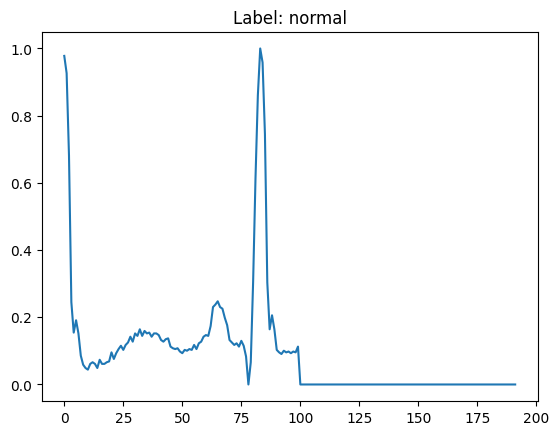

In [5]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");

In [6]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

In [7]:
from torch import Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [8]:
# streamer:         (batch, seq_len, channels)
# conv1d:           (batch, channels, seq_len)
# pos_encoding:     (batch, seq_len, channels)
# gru (batchfirst): (batch, seq_len, channels)
# attention:        (batch, seq_len, channels)

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone()
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity)
        identity = x.clone()
        x = self.ff(x)
        x = self.layer_norm2(x + identity)
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv1d:           (batch, channels, seq_len)
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2))
        x = self.pos_encoder(x.transpose(1, 2))

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1)
        x = self.out(x)
        return x

In [10]:
# from src import models
# config = {
#     "hidden": 128,
#     "dropout": 0.1,
#     "output": 2,
#     "num_heads": 4,
#     "num_blocks": 3,
# }
# model = models.Transformer(config)

In [11]:
# x, y = next(trainstreamer.stream())
# x.shape, y.shape

In [12]:
# yhat = model(x)
# yhat.shape

In [13]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [14]:
from mads_datasets.base import BaseDatastreamer
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from pathlib import Path
from typing import Dict

import ray
import torch
from filelock import FileLock
from loguru import logger
from mltrainer import ReportTypes, Trainer, TrainerSettings
from mltrainer.preprocessors import PaddedPreprocessor
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

import models

SAMPLE_INT = tune.search.sample.Integer
SAMPLE_FLOAT = tune.search.sample.Float

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

def train(config: Dict):
    """
    The train function should receive a config file, which is a Dict
    ray will modify the values inside the config before it is passed to the train
    function.
    """
    
    model = models.Transformer(config)
    model.to(device)

    trainersettings = TrainerSettings(
        epochs=5,
        metrics=[accuracy],
        logdir="heart1DBIG",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),  # type: ignore
        reporttypes=[ReportTypes.RAY],
        scheduler_kwargs={"factor": 0.5, "patience": 5},
        earlystop_kwargs=None,
    )

    # because we set reporttypes=[ReportTypes.RAY]
    # the trainloop wont try to report back to tensorboard,
    # but will report back with ray
    # this way, ray will know whats going on,
    # and can start/pause/stop a loop.
    # This is why we set earlystop_kwargs=None, because we
    # are handing over this control to ray.

    trainer = Trainer(
        model=model,
        settings=trainersettings,
        loss_fn=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam,  # type: ignore
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    )

    trainer.loop()


In [22]:
from pathlib import Path

tune_dir = Path("../../models/ray/")
tune_dir.exists(), tune_dir.resolve()

if __name__ == "__main__":
    try:
        ray.init()
    except:
        ray.shutdown()
        ray.init()

    config = {
        # "input_size": 1, irrelevant
        "num_classes": 5,      #2 for small one
        "tune_dir": tune_dir,
        "dropout":  0.1,
        "hidden":  128, #tune.randint(64, 256),
        "num_heads": tune.randint(4,16),
        "num_blocks": 2 #tune.randint(2,3)
    }
    reporter = CLIReporter()
    reporter.add_metric_column("accuracy")
    reporter.add_metric_column("precision")
    reporter.add_metric_column("recall")

    bohb_hyperband = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=50,
        reduction_factor=3,
        stop_last_trials=False,
    )

    bohb_search = TuneBOHB()

    analysis = tune.run(
        train,
        config=config,
        metric="test_loss",
        mode="min",
        progress_reporter=reporter,
        # local_dir=str(config["tune_dir"]),
        num_samples=20,
        search_alg=bohb_search,
        scheduler=bohb_hyperband,
        verbose=1,
    )

    ray.shutdown()


2024-01-30 15:46:11,890	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-30 15:46:12,844	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


ValueError: Tracked actor is not managed by this event manager: <TrackedActor 91649135076768202010598653429442980430>

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=5,
    metrics=[accuracy, f1micro, f1macro, precision, recall],
    logdir="heart1D",
    train_steps=len(trainstreamer),
    valid_steps=len(teststreamer),
    reporttypes=[ReportTypes.TENSORBOARD],
    scheduler_kwargs={"factor": 0.5, "patience": 5},
    earlystop_kwargs=None
)
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer.stream(),
    validdataloader=teststreamer.stream(),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
    )
trainer.loop()

NameError: name 'model' is not defined

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

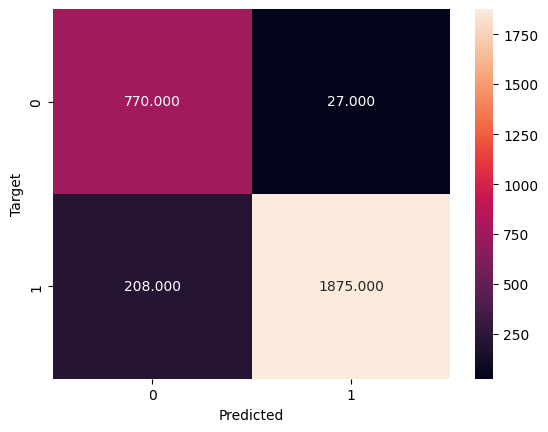

In [14]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")